In [155]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [156]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [158]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.75
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [159]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/home/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [160]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [161]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [162]:
example_data.shape

torch.Size([1000, 1, 28, 28])

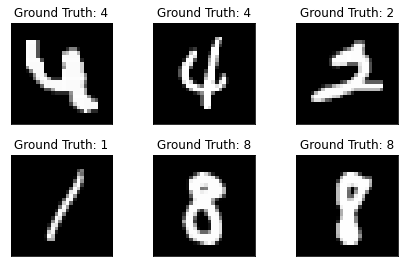

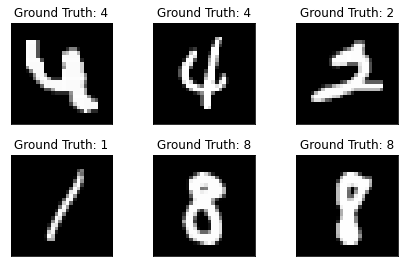

In [163]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [164]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [165]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [166]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [167]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [168]:
def grad_flow(named_parameters):
  grad_tensor = torch.zeros(0)
  grad_tensor=grad_tensor.to(device)
  for n, p in named_parameters:
    print(n)
    if p.requires_grad and "bias" not in n:
      curr_tensor = torch.flatten(p.grad.data)
      print(curr_tensor.size())
      grad_tensor = torch.cat((grad_tensor,curr_tensor),0)
    #print(torch.norm(torch.flatten(p.grad.data)))
  grad_norms.append(grad_tensor.norm().item())
     

In [169]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/home/model.pth')
      torch.save(optimizer.state_dict(), '/home/optimizer.pth')
      print("PRINT PARAMETERS")
  grad_flow(network.named_parameters())

In [170]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [171]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
PRINT PARAMETERS
Train Epoch: 76 [24320/60000 (41%)]	Loss: 2.306430
PRINT PARAMETERS
Train Epoch: 76 [24960/60000 (42%)]	Loss: 2.299745
PRINT PARAMETERS
Train Epoch: 76 [25600/60000 (43%)]	Loss: 2.299589
PRINT PARAMETERS
Train Epoch: 76 [26240/60000 (44%)]	Loss: 2.305458
PRINT PARAMETERS
Train Epoch: 76 [26880/60000 (45%)]	Loss: 2.312129
PRINT PARAMETERS
Train Epoch: 76 [27520/60000 (46%)]	Loss: 2.292947
PRINT PARAMETERS
Train Epoch: 76 [28160/60000 (47%)]	Loss: 2.304672
PRINT PARAMETERS
Train Epoch: 76 [28800/60000 (48%)]	Loss: 2.307118
PRINT PARAMETERS
Train Epoch: 76 [29440/60000 (49%)]	Loss: 2.304290
PRINT PARAMETERS
Train Epoch: 76 [30080/60000 (50%)]	Loss: 2.301002
PRINT PARAMETERS
Train Epoch: 76 [30720/60000 (51%)]	Loss: 2.300029
PRINT PARAMETERS
Train Epoch: 76 [31360/60000 (52%)]	Loss: 2.291438
PRINT PARAMETERS
Train Epoch: 76 [32000/60000 (53%)]	Loss: 2.297799
PRINT PARAMETERS
Train Epoch: 76 [32640/60000 (54%)]	Loss: 2.3067

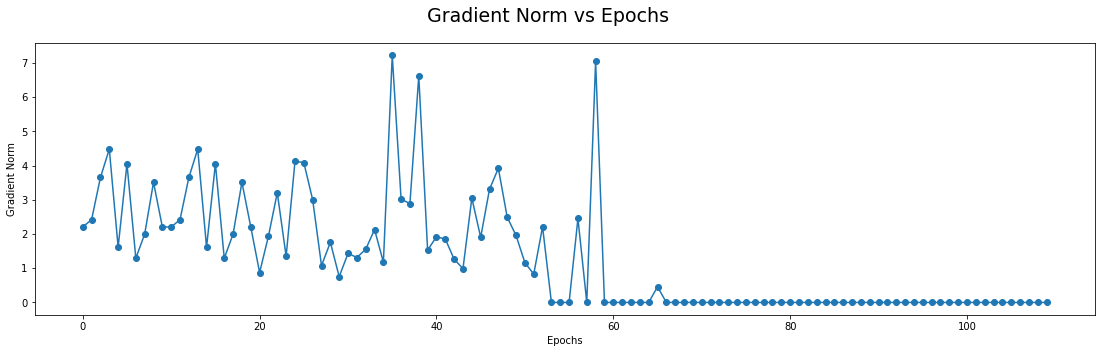

In [172]:

x = np.arange(len(grad_norms))
fig = plt.gcf()
fig.set_size_inches(19, 5)
fig.suptitle('Gradient Norm vs Epochs', fontsize=19)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Gradient Norm', fontsize=10)
plt.scatter(x,grad_norms)
plt.plot(x,grad_norms)
plt.savefig('Gradient Norm vs Epoch(100).jpg')


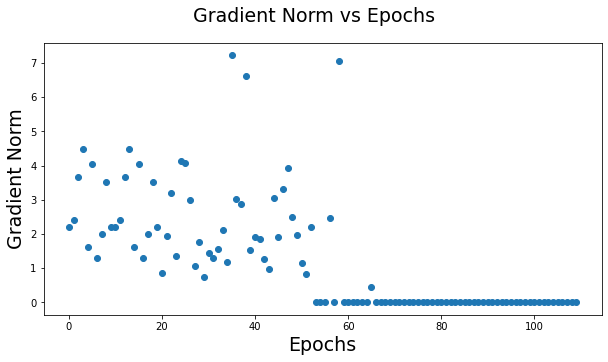

In [173]:
x = np.arange(len(grad_norms))
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.suptitle('Gradient Norm vs Epochs', fontsize=19)
plt.xlabel('Epochs', fontsize=19)
plt.ylabel('Gradient Norm', fontsize=19)
plt.scatter(x,grad_norms)
plt.savefig('Gradient Norm vs Epoch(100) scatter.jpg')